In [1]:

import os
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError
from sktime.forecasting.compose import ColumnEnsembleForecaster

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils

import os
import importlib
import joblib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.forecasting.model_evaluation import evaluate

from sktime.transformations.series.detrend import Deseasonalizer, Detrender



from sktime.split import temporal_train_test_split
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.forecasting.darts import DartsXGBModel 


from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV,
)
from scipy.stats import randint, uniform        # for random search



# DATA PREPARATION

In [4]:
# Define the paths
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
output_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\benchmarks'
processed_data_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\processed'
pipeline_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\pipelines'

data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)

# NOTE Truncate the processed data to only include the first 6 months (from Jan 1st to Jun 30th, 2024)
processed_data = processed_data.loc['2024-01-01':'2024-03-30']


processed_data.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [5]:
processed_data_Y = processed_data[['WVHT', 'APD']].copy()
processed_data_X = processed_data.drop(columns=['WVHT', 'APD'])

one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)

y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=horizon_steps*3)


In [6]:

pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

X_train_transformed = pipe_X.fit_transform(X_train)
X_test_transformed  = pipe_X.transform(X_test)
Y_train_transformed = pipe_Y.fit_transform(y_train)
Y_test_transformed  = pipe_Y.transform(y_test)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Total number of evaluations 9


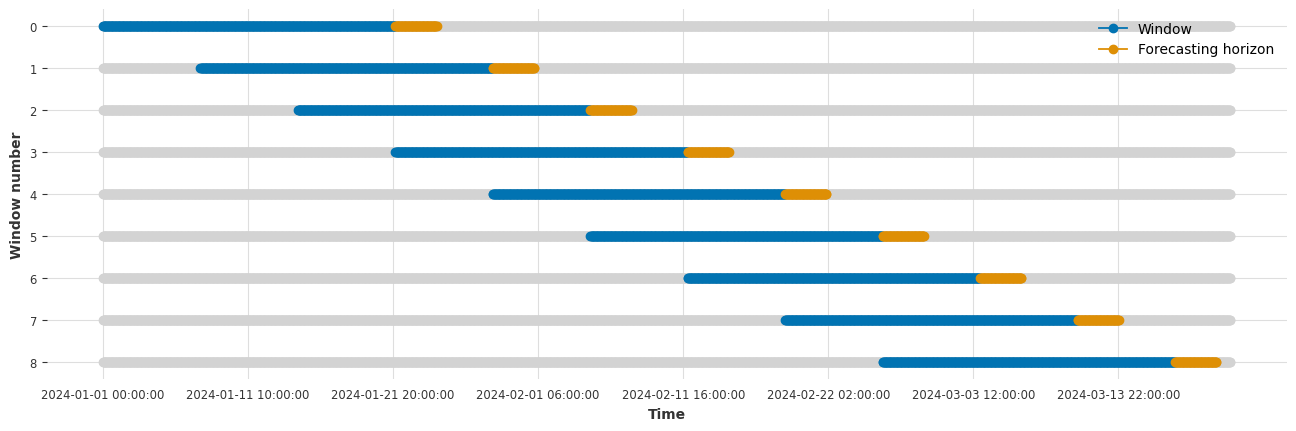

In [49]:


cv = SlidingWindowSplitter(fh=fh, window_length=training_window, step_length = one_week)
print("Total number of evaluations",(cv.get_n_splits(Y_train_transformed)))
plot_windows(cv=cv, y=Y_train_transformed[:]) # Plotting for the first 6 weeks of data


    # Define metrics
scorers = [
        MeanSquaredPercentageError(),
        MeanAbsolutePercentageError()
    ]


# DARTSXGBOOST

In [10]:
from sktime.forecasting.darts import DartsXGBModel  # the wrapper
import xgboost as xgb

lags_Y  = [-1,-2,-3,-24,-48]       # target history
lags_X  = [-1,-2,-3,-24,-48]           # exogenous history (all columns in X)

# Horizon (max step the CV splitter ever asks for)
encoders = {
    "datetime_attribute": {
        "past":   ["hour", "month"],
        "future": ["hour",  "month"],
    }
}


lr_scheduler = xgb.callback.LearningRateScheduler(forecasting_utils.lr_schedule)




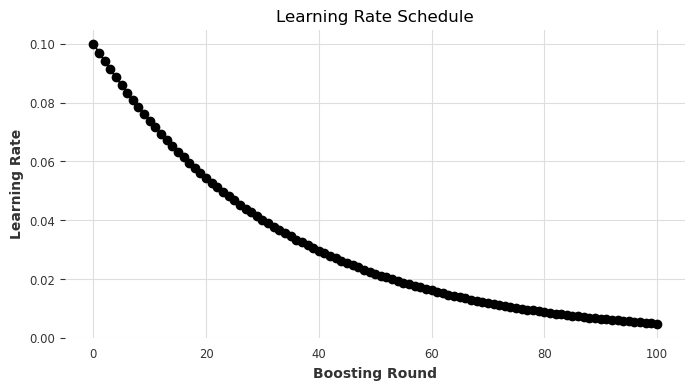

In [47]:
rounds = list(range(0, 101))
lrs = [forecasting_utils.lr_schedule(r) for r in rounds]

plt.figure(figsize=(8, 4))
plt.plot(rounds, lrs, marker='o')
plt.xlabel("Boosting Round")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

In [ ]:
xgb_kwargs = dict(
    n_estimators        = 2500,
    learning_rate       = 0.3,
    max_depth           = 100,
    subsample           = 0.8,
    colsample_bytree    = 0.8,
    objective           = "reg:squarederror",
    n_jobs              = -1,     # <‑‑ all threads
    # early stopping if you pass eval_set later:
    # early_stopping_rounds = 50, eval_metric = "rmse",
)

forecaster = DartsXGBModel(
    lags                 = lags_Y,
    lags_past_covariates = lags_X,
    output_chunk_length  = int(cv.fh[-1]),
    add_encoders         = encoders,
    random_state         = 42,
    multi_models         = False,   # one XGB for every horizon step
    kwargs               = xgb_kwargs,
)


In [63]:
results = evaluate(
    forecaster      = forecaster,
    y               = Y_train_transformed,
    X               = X_train_transformed,   # all columns = past covariates
    cv              = cv,
    strategy        = "refit",
    scoring         = scorers,
    backend         = "loky",
    backend_params  = {"n_jobs": -1},        # parallel folds
    return_data     = True,
    return_model    = True,
)

In [58]:
# SUmmarize the evualtion results
if 'fitted_forecaster' in results.columns:
    first_fold_forecaster = results['fitted_forecaster'].iloc[0]
    print("\nFitted forecaster type for first fold:", type(first_fold_forecaster).__name__)
    
    # Check if this is a multivariate forecaster (will use ColumnEnsembleForecaster)
    if  type(first_fold_forecaster).__name__ == 'ColumnEnsembleForecaster':
        print("\nThis is a multivariate forecaster with individual models for each target variable:")
        print(first_fold_forecaster)
        
        # For ColumnEnsembleForecaster, the forecasters are stored as a list of tuples
        forecasters = first_fold_forecaster.get_params()['forecasters']
        for name, individual_forecaster, target_idx in forecasters:
            strategy = individual_forecaster.get_params().get('strategy', 'Not specified')
            print(f"  Model for target {target_idx}: {type(individual_forecaster).__name__} "
                  f"with name '{name}' and strategy '{strategy}'")
    else:
        print("\nThis is a single-target forecaster")

# Print summary of results
forecasting_utils.summarize_cv_score(scorers, results)

best_fold_idx, best_model = forecasting_utils.export_bestmodel_and_results(results, output_dir=output_dir, 
                                                         metric="test_MeanSquaredPercentageError")


Fitted forecaster type for first fold: DartsXGBModel

This is a single-target forecaster
Fold 0:
  MeanSquaredPercentageError for WVHT: 17.7484
  MeanSquaredPercentageError for APD: 4.9054
  MeanAbsolutePercentageError for WVHT: 1.9403
  MeanAbsolutePercentageError for APD: 1.5643
Fold 1:
  MeanSquaredPercentageError for WVHT: 395.0796
  MeanSquaredPercentageError for APD: 20.1997
  MeanAbsolutePercentageError for WVHT: 4.9172
  MeanAbsolutePercentageError for APD: 1.9687
Fold 2:
  MeanSquaredPercentageError for WVHT: 8.0638
  MeanSquaredPercentageError for APD: 13.0847
  MeanAbsolutePercentageError for WVHT: 1.2686
  MeanAbsolutePercentageError for APD: 1.6687
Fold 3:
  MeanSquaredPercentageError for WVHT: 3.3339
  MeanSquaredPercentageError for APD: 12.8094
  MeanAbsolutePercentageError for WVHT: 1.0424
  MeanAbsolutePercentageError for APD: 1.7506
Fold 4:
  MeanSquaredPercentageError for WVHT: 0.3919
  MeanSquaredPercentageError for APD: 1038.4193
  MeanAbsolutePercentageError for 

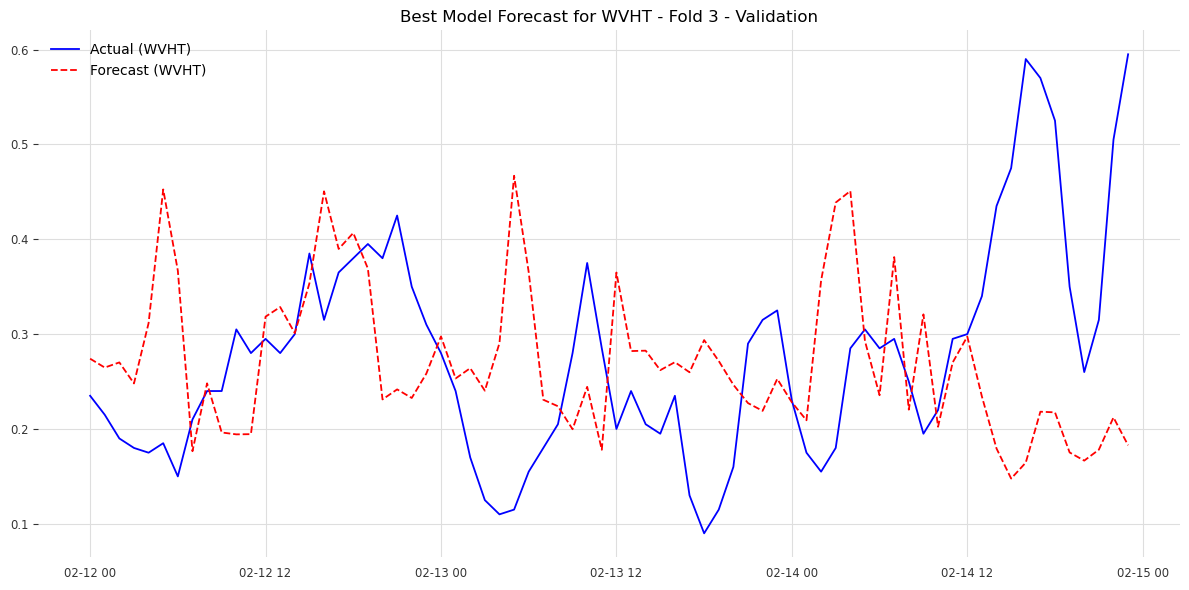

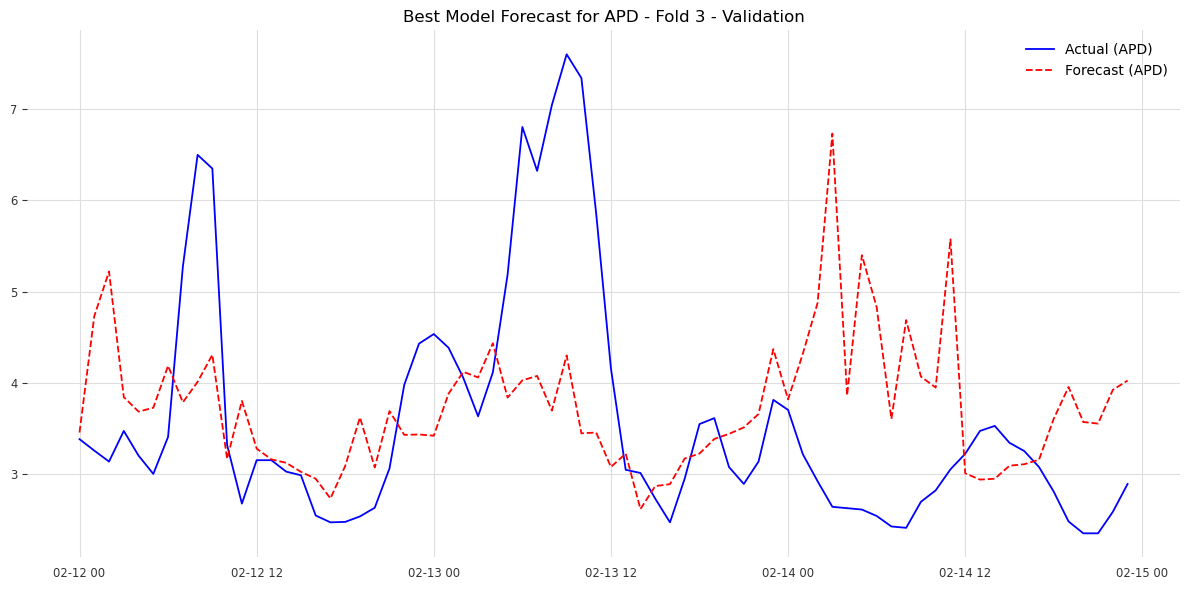

MeanSquaredPercentageError → 0.3570
MeanAbsolutePercentageError → 0.4001


In [59]:
# Comparing the prediction of the best model with test data
y_pred = best_model.predict(fh=fh, X=X_train_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            # Plot test and predictions
            plt.plot(y_train[target].loc[y_pred.index], label=f'Actual ({target})', color='blue')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target} - Fold {best_fold_idx} - Validation')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_train.loc[y_pred.index], y_pred)
    print(f"{name} → {value:.4f}")

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Models Cutoff Date: 2024-02-11 23:00:00
X_test Start Date: 2024-03-22 00:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


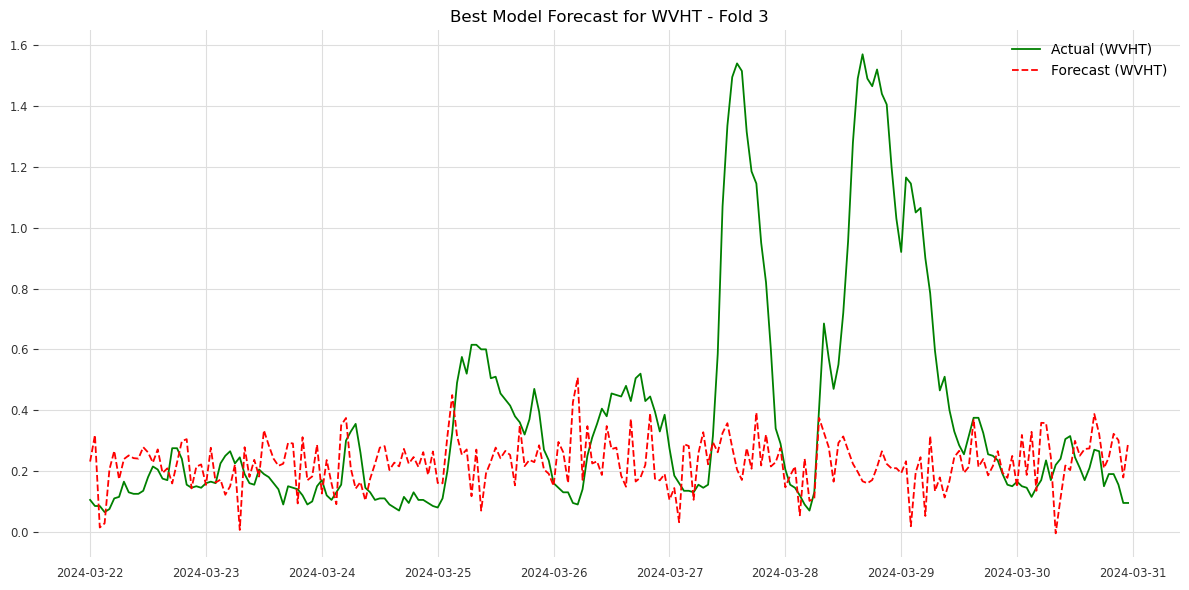

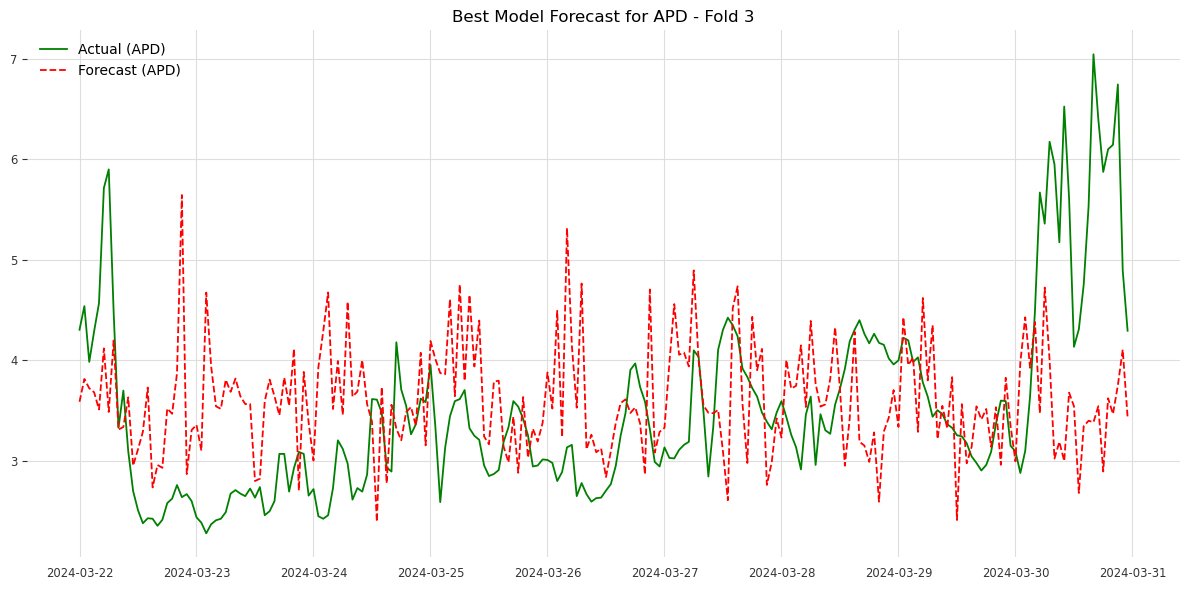

MeanSquaredPercentageError → 0.4188
MeanAbsolutePercentageError → 0.4487


In [ ]:
# Comparing the prediction of the best model with test data
y_pred = forecasting_utils.forecast_with_exog(best_model, X_train_transformed, X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='blue')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target} - Fold {best_fold_idx} - Testing')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


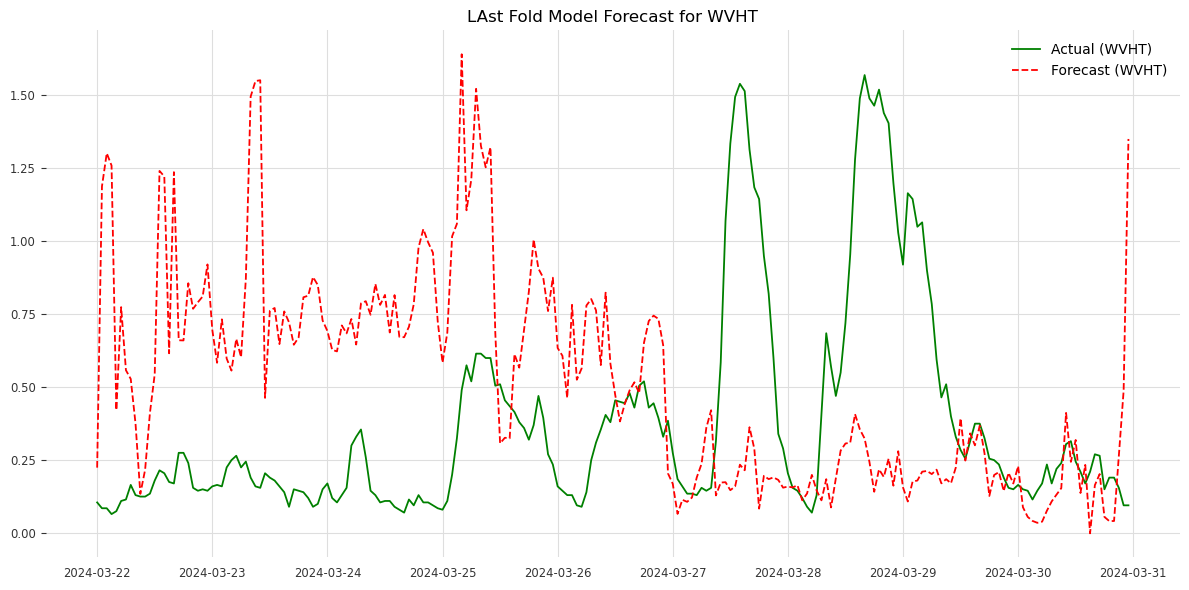

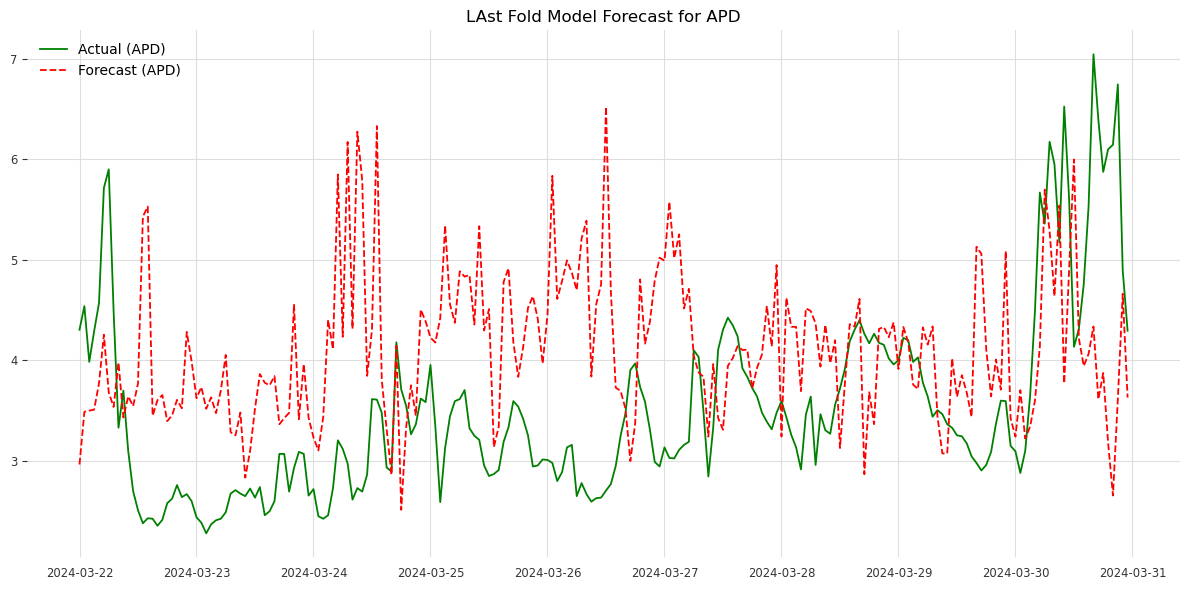

MeanSquaredPercentageError → 6.8412
MeanAbsolutePercentageError → 1.3159


In [ ]:
# Comparing the prediction of the last model with test data
best_model = results['fitted_forecaster'].iloc[-1]
y_pred = best_model.predict(fh =  ForecastingHorizon(y_test.index, is_relative=False), X = X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='blue')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'LAst Fold Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

# XGBOOST

In [148]:
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import FeatureUnion, Pipeline


## Feature Engg

In [108]:


# --  helpers ---------------------------------------------------
def _add_calendar(X):
    X = X.copy()
    X["month"] = X.index.month
    X["hour"]  = X.index.hour
    return X

calendar_tf = FunctionTransformer(_add_calendar, validate=False)

lag_roll_tf = WindowSummarizer(
    lag_feature = {"lag": [1, 24, 28],
                   "mean": [[1, 24]]},
    truncate    = "bfill",
)

feat_union = FeatureUnion([
    ("calendar", calendar_tf),
    ("lag_roll", lag_roll_tf),
])

feat_pipeline = Pipeline([
    ("features", feat_union),
    ("scaler",   StandardScaler()),
])

# --  build features -------------------------------------------
def make_features(X_scaled, y_scaled, fit=False):
    # Adds the y target varaiables to X so that feature engineering can be done on both
    Xy = pd.concat([pd.DataFrame(X_scaled, index=X_scaled.index, columns=X_train.columns),
                    pd.DataFrame(y_scaled, index=y_scaled.index, columns=y_train.columns)],
                   axis=1)
    if fit:
        # Fit the feature pipeline on the training data
        Xy = feat_pipeline.fit_transform(Xy)
        return pd.DataFrame(Xy, index=X_scaled.index)
    else: 
        # Transform the test data using the fitted pipeline
        Xy = feat_pipeline.transform(Xy)
        return pd.DataFrame(Xy, index=X_scaled.index)


X_feat_train = make_features(X_train_transformed, Y_train_transformed, fit=True)
X_feat_test  = make_features(X_test_transformed,  Y_test_transformed)

In [112]:
xgb_kwargs = dict(
    # ––– capacity / speed –––
    n_estimators      = 800,
    learning_rate     = 0.05,
    max_depth         = 6,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    tree_method       = "hist",      # fastest on CPU
    # ––– regularisation –––
    min_child_weight  = 1.0,
    gamma             = 0.0,
    reg_alpha         = 0.0,
    reg_lambda        = 1.0,
    # ––– misc –––
    objective         = "reg:squarederror",
    random_state      = 42,
    n_jobs            = -1,
    device          = "cuda",
)

regressor  = XGBRegressor(**xgb_kwargs)

forecaster = make_reduction(regressor,
    window_length  = training_window,  
    strategy       = "recursive"
)

forecaster.fit(y=Y_train_transformed, X=X_feat_train)

RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, num_parallel_tree=None, ...),
                                     window_length=504)

## TESTING 

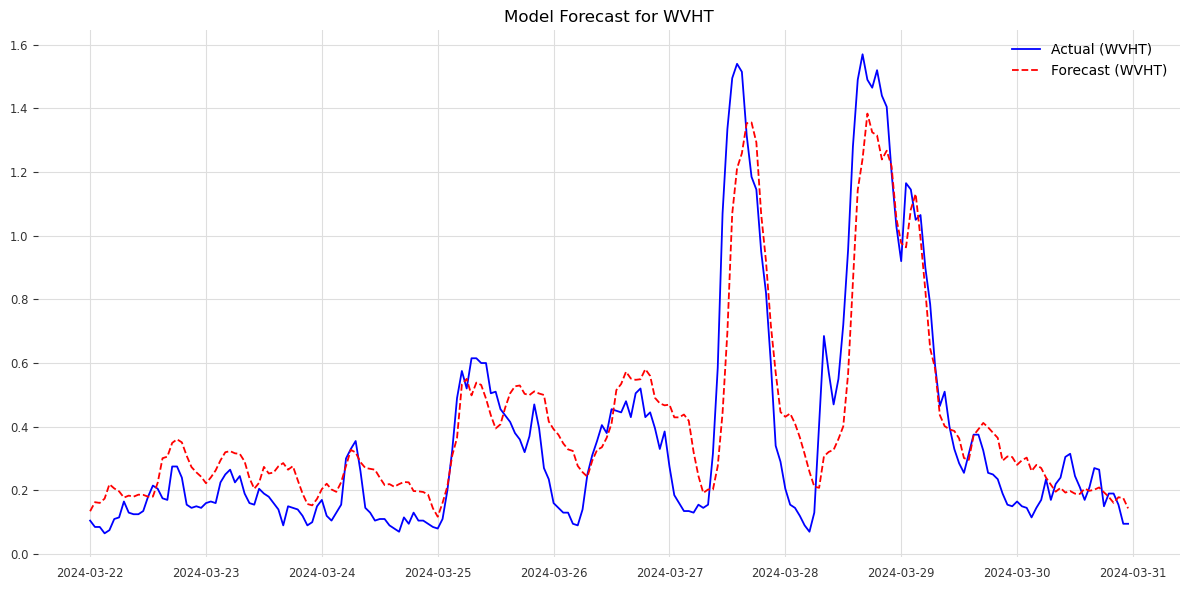

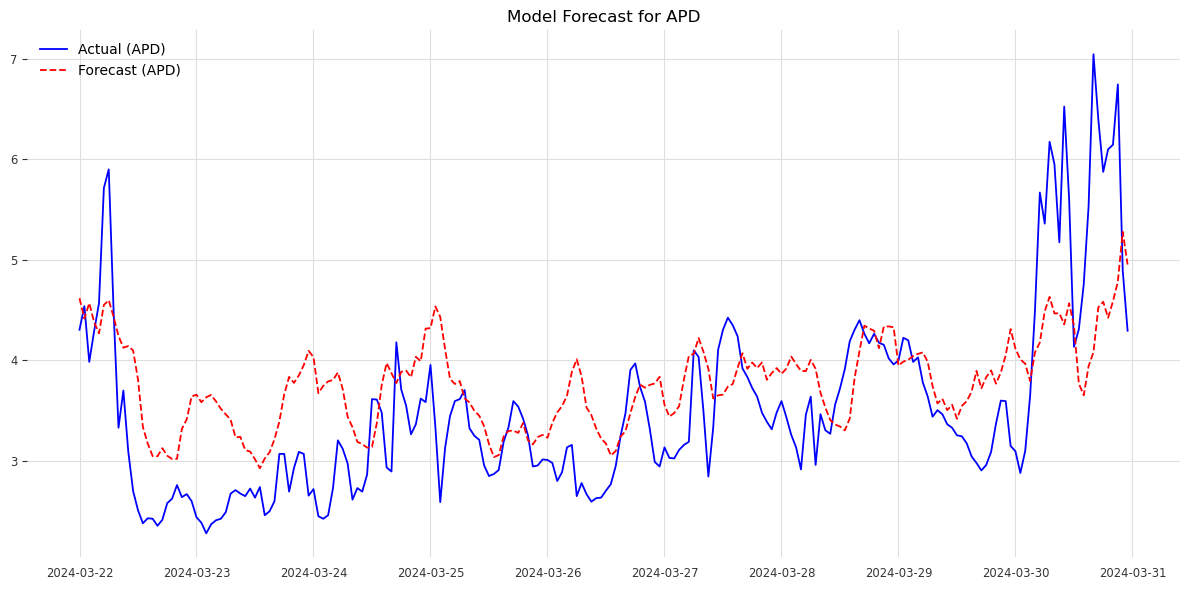

MeanSquaredPercentageError → 0.3315
MeanAbsolutePercentageError → 0.3659


In [113]:
y_pred = forecaster.predict(fh=ForecastingHorizon(y_test.index, is_relative=False), X=X_feat_test)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='blue')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")